#Σακαρέλλος Ιωάννης - sdi1800167

In [ ]:
import torch
import torchvision
import librosa.display

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from torch.optim import SGD
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip '/content/gdrive/MyDrive/Machine Learning/HW3/Data/data.zip' -d '/content/gdrive/MyDrive/Machine Learning/HW3/Data/'


data_url = r'/content/gdrive/MyDrive/Machine Learning/HW3/Data/music_genre_data_di'

mapping = {'blues' : 0,
           'classical' : 1,
           'hiphop' : 2,
           'rock_metal_hardrock' : 3}

Archive:  /content/gdrive/MyDrive/Machine Learning/HW3/Data/data.zip
replace /content/gdrive/MyDrive/Machine Learning/HW3/Data/music_genre_data_di/test/melgrams/X.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


##Ερώτημα 1: Feedforward Neural Network

###Βήμα 1: Φόρτωση Δεδομένων (MFCCs)

In [ ]:
mfcc_trainX = np.load(data_url + '/train/mfccs/X.npy')
mfcc_trainY = np.load(data_url + '/train/mfccs/labels.npy')

mfcc_testX = np.load(data_url + '/test/mfccs/X.npy')
mfcc_testY = np.load(data_url + '/test/mfccs/labels.npy')

mfcc_valX = np.load(data_url + '/val/mfccs/X.npy')
mfcc_valY = np.load(data_url + '/val/mfccs/labels.npy')

In [ ]:
mfcc_trainY = np.array([mapping[label] for label in mfcc_trainY])

mfcc_testY = np.array([mapping[label] for label in mfcc_testY])

mfcc_valY = np.array([mapping[label] for label in mfcc_valY])

In [ ]:
mfcc_trainX[0]

array([-2.62640284e+01,  3.50238316e+00,  1.08797911e+00,  3.99411198e-01,
        5.33732920e-01,  3.13589575e-01, -2.48267521e-02,  2.64692240e-01,
        1.83268396e-02,  6.04936474e-02, -2.37525896e-01, -2.91073564e-03,
        3.44489057e-02,  1.51350842e+00,  6.21633735e-01,  3.05950256e-01,
        2.60451193e-01,  1.79726246e-01,  2.07318222e-01,  2.77934742e-01,
        2.13824074e-01,  1.78887478e-01,  1.28970384e-01,  2.00535542e-01,
        1.69736069e-01,  1.83230535e-01])

In [ ]:
class trainDataSetMFCC(Dataset):
  def __init__(self):
    self.x = torch.Tensor(mfcc_trainX.tolist())
    self.y = torch.LongTensor(mfcc_trainY.tolist())

    self.n_samples = len(self.x)

  def __getitem__(self, index):
    return self.x[index], self.y[index]

  def __len__(self):
    return self.n_samples


class testDataSetMFCC(Dataset):
  def __init__(self):
    self.x = torch.Tensor(mfcc_testX.tolist())
    self.y = torch.LongTensor(mfcc_testY.tolist())

    self.n_samples = len(self.x)

  def __getitem__(self, index):
    return self.x[index], self.y[index]

  def __len__(self):
    return self.n_samples


class valDataSetMFCC(Dataset):
  def __init__(self):
    self.x = torch.Tensor(mfcc_valX.tolist())
    self.y = torch.LongTensor(mfcc_valY.tolist())

    self.n_samples = len(self.x)

  def __getitem__(self, index):
    return self.x[index], self.y[index]

  def __len__(self):
    return self.n_samples

In [ ]:
trainLoaderMFCC = DataLoader(dataset=trainDataSetMFCC(), batch_size=16, shuffle=True)

testLoaderMFCC = DataLoader(dataset=testDataSetMFCC(), batch_size=16, shuffle=False)

valLoaderMFCC = DataLoader(dataset=valDataSetMFCC(), batch_size=16, shuffle=True)

###Βήμα 2: Ορισμός Νευρωνικού Δικτύου

In [ ]:
class NN(nn.Module):
  def __init__(self, input_size=26, num_classes=4):
    super(NN, self).__init__()

    self.fc1 = nn.Linear(input_size, 128)
    self.fc2 = nn.Linear(128, 32)
    self.fc3 = nn.Linear(32, num_classes)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x

###Βήμα 3: Ορισμός Διαδικασίας Εκπαίδευσης

In [ ]:
def train_model(epochs, optimizer, dataloader, cost_func, model, device='cpu'):
  device = torch.device(device)

  for epoch in range(epochs):
    print('Epoch No ', epoch, '\n================', sep='')

    for batch, (data, targets) in enumerate(dataloader):
      data = data.to(device=device)
      targets = targets.to(device=device)

      scores = model(data)
      loss = cost_func(scores, targets)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      print('Batch No ', batch, ',\tloss is ', loss, sep='')

    print('')

  return model

###Βήμα 4: Ορισμός Διαδικασίας Αξιολόγησης

In [ ]:
def eval_model(dataloader, cost_func, model, device='cpu'):
  device = torch.device(device)

  model.eval()
  with torch.no_grad():

    scores_all = []
    targets_all = []

    for data, targets in dataloader:
      data = data.to(device=device)
      targets = targets.to(device=device)

      scores = model(data)

      scores_all.append(scores)
      targets_all.append(targets)

    scores_all = torch.cat(scores_all, 0).cpu()
    targets_all = torch.cat(targets_all, 0).cpu()

    _, pred = scores_all.max(1)

    loss = cost_func(scores_all, targets_all)
    f1 = f1_score(targets_all, pred, average='macro')
    acc = accuracy_score(targets_all, pred)
    mat = confusion_matrix(targets_all, pred)

    print('Loss:\t\t\t\t', loss)
    print('F1 Macro-Averaged Score:\t', f1)
    print('Accuracy:\t\t\t', acc)
    print('Confusion Matrix:\t', mat, '\n')

  model.train()

###Βήμα 5: Εκπαίδευση Δικτύου

In [ ]:
model = NN(input_size=26, num_classes=4).to(torch.device('cpu'))

train_model(epochs=30, optimizer=SGD(model.parameters(), lr=0.002), dataloader=trainLoaderMFCC, cost_func=nn.CrossEntropyLoss(), model=model)

Streaming output truncated to the last 5000 lines.
Batch No 73,	loss is tensor(1.3579, grad_fn=<NllLossBackward0>)
Batch No 74,	loss is tensor(1.3345, grad_fn=<NllLossBackward0>)
Batch No 75,	loss is tensor(1.3450, grad_fn=<NllLossBackward0>)
Batch No 76,	loss is tensor(1.3641, grad_fn=<NllLossBackward0>)
Batch No 77,	loss is tensor(1.3580, grad_fn=<NllLossBackward0>)
Batch No 78,	loss is tensor(1.3679, grad_fn=<NllLossBackward0>)
Batch No 79,	loss is tensor(1.3153, grad_fn=<NllLossBackward0>)
Batch No 80,	loss is tensor(1.3714, grad_fn=<NllLossBackward0>)
Batch No 81,	loss is tensor(1.3366, grad_fn=<NllLossBackward0>)
Batch No 82,	loss is tensor(1.3447, grad_fn=<NllLossBackward0>)
Batch No 83,	loss is tensor(1.3377, grad_fn=<NllLossBackward0>)
Batch No 84,	loss is tensor(1.3699, grad_fn=<NllLossBackward0>)
Batch No 85,	loss is tensor(1.3648, grad_fn=<NllLossBackward0>)
Batch No 86,	loss is tensor(1.3566, grad_fn=<NllLossBackward0>)
Batch No 87,	loss is tensor(1.3213, grad_fn=<NllLossB

NN(
  (fc1): Linear(in_features=26, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=4, bias=True)
)

In [ ]:
eval_model(dataloader=testLoaderMFCC, cost_func=nn.CrossEntropyLoss(), model=model)

Loss:				 tensor(1.0166)
F1 Macro-Averaged Score:	 0.5251342357566521
Accuracy:			 0.5675872093023255
Confusion Matrix:	 [[ 38  48  49 189]
 [ 11 260   5  21]
 [ 39  36 172 109]
 [  9  50  29 311]] 



###Βήμα 6: Εκπαίδευση Δικτύου με GPU

In [ ]:
model = NN(input_size=26, num_classes=4).to(torch.device('cuda'))

train_model(epochs=30, optimizer=SGD(model.parameters(), lr=0.002), dataloader=trainLoaderMFCC, cost_func=nn.CrossEntropyLoss(), model=model, device='cuda')

Streaming output truncated to the last 5000 lines.
Batch No 73,	loss is tensor(1.3009, device='cuda:0', grad_fn=<NllLossBackward0>)
Batch No 74,	loss is tensor(1.2807, device='cuda:0', grad_fn=<NllLossBackward0>)
Batch No 75,	loss is tensor(1.2501, device='cuda:0', grad_fn=<NllLossBackward0>)
Batch No 76,	loss is tensor(1.3610, device='cuda:0', grad_fn=<NllLossBackward0>)
Batch No 77,	loss is tensor(1.3380, device='cuda:0', grad_fn=<NllLossBackward0>)
Batch No 78,	loss is tensor(1.2800, device='cuda:0', grad_fn=<NllLossBackward0>)
Batch No 79,	loss is tensor(1.3033, device='cuda:0', grad_fn=<NllLossBackward0>)
Batch No 80,	loss is tensor(1.3501, device='cuda:0', grad_fn=<NllLossBackward0>)
Batch No 81,	loss is tensor(1.3139, device='cuda:0', grad_fn=<NllLossBackward0>)
Batch No 82,	loss is tensor(1.3399, device='cuda:0', grad_fn=<NllLossBackward0>)
Batch No 83,	loss is tensor(1.2947, device='cuda:0', grad_fn=<NllLossBackward0>)
Batch No 84,	loss is tensor(1.3120, device='cuda:0', grad_

NN(
  (fc1): Linear(in_features=26, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=4, bias=True)
)

In [ ]:
eval_model(dataloader=testLoaderMFCC, cost_func=nn.CrossEntropyLoss(), model=model, device='cuda')

Loss:				 tensor(1.0312)
F1 Macro-Averaged Score:	 0.5278096386528143
Accuracy:			 0.5450581395348837
Confusion Matrix:	 [[102  84  37 101]
 [ 20 268   2   7]
 [137  43 128  48]
 [ 39  84  24 252]] 



Παρατηρούμε ότι η εκπαίδευση του μοντέλου στη CPU έγινε σε περίπου 21 δευτερόλεπτα, ενώ στη GPU σε 28

###Βήμα 7: Επιλογή Μοντέλου

In [ ]:
def train_model_select(epochs, optimizer, trainloader, valloader, cost_func, model, device='cpu'):
  device = torch.device(device)
  max_f1 = 0

  for epoch in range(epochs):
    for batch, (data, targets) in enumerate(trainloader):
      data = data.to(device=device)
      targets = targets.to(device=device)

      scores = model(data)
      loss = cost_func(scores, targets)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    model.eval()
    with torch.no_grad():
      scores_all = []
      targets_all = []

      for data, targets in valloader:
        data = data.to(device=device)
        targets = targets.to(device=device)

        scores = model(data)

        scores_all.append(scores)
        targets_all.append(targets)

      scores_all = torch.cat(scores_all, 0)
      targets_all = torch.cat(targets_all, 0)

      _, pred = scores_all.max(1)

      f1 = f1_score(targets_all, pred, average='macro')

    model.train()

    if f1 > max_f1:
      max_f1 = f1
      best_model = model

  return best_model

In [ ]:
model = NN(input_size=26, num_classes=4).to(torch.device('cpu'))

model = train_model_select(epochs=30, optimizer=SGD(model.parameters(), lr=0.002), trainloader=trainLoaderMFCC, valloader=valLoaderMFCC, cost_func=nn.CrossEntropyLoss(), model=model, device='cpu')
eval_model(dataloader=testLoaderMFCC, cost_func=nn.CrossEntropyLoss(), model=model, device='cpu')

Loss:				 tensor(1.0582)
F1 Macro-Averaged Score:	 0.580742241418351
Accuracy:			 0.5879360465116279
Confusion Matrix:	 [[ 86  26  58 154]
 [ 47 228   6  16]
 [ 74  13 212  57]
 [ 51  26  39 283]] 



##Ερώτημα 2: Convolutional Neural Networks

###Βήμα 1: Φόρτωση Δεδομένων (Spectograms)

In [ ]:
mel_trainX = np.load(data_url + '/train/melgrams/X.npy')
mel_trainY = np.load(data_url + '/train/melgrams/labels.npy')

mel_testX = np.load(data_url + '/test/melgrams/X.npy')
mel_testY = np.load(data_url + '/test/melgrams/labels.npy')

mel_valX = np.load(data_url + '/val/melgrams/X.npy')
mel_valY = np.load(data_url + '/val/melgrams/labels.npy')

In [ ]:
mel_trainY = np.array([mapping[label] for label in mel_trainY])

mel_testY = np.array([mapping[label] for label in mel_testY])

mel_valY = np.array([mapping[label] for label in mel_valY])

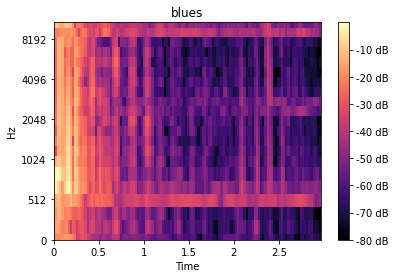

In [ ]:
fig, ax = plt.subplots()

img = librosa.display.specshow(mel_trainX[np.where(mel_trainY == 0)[0][0]], x_axis='time', y_axis='mel', ax=ax)
ax.set(title='blues')
plt.colorbar(img, format='%+2.0f dB')

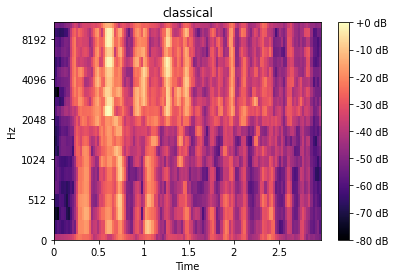

In [ ]:
fig, ax = plt.subplots()

img = librosa.display.specshow(mel_trainX[np.where(mel_trainY == 1)[0][0]], x_axis='time', y_axis='mel', ax=ax)
ax.set(title='classical')
plt.colorbar(img, format='%+2.0f dB')

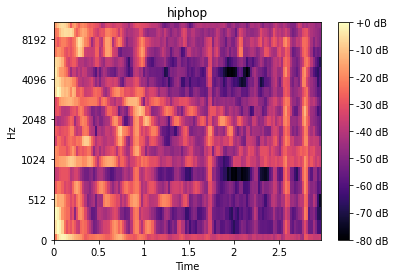

In [ ]:
fig, ax = plt.subplots()

img = librosa.display.specshow(mel_trainX[np.where(mel_trainY == 2)[0][0]], x_axis='time', y_axis='mel', ax=ax)
ax.set(title='hiphop')
plt.colorbar(img, format='%+2.0f dB')

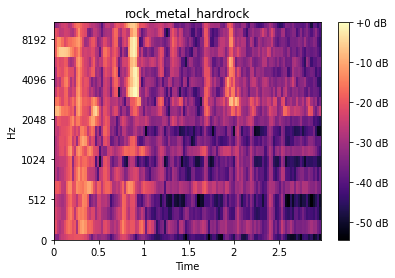

In [ ]:
fig, ax = plt.subplots()

img = librosa.display.specshow(mel_trainX[np.where(mel_trainY == 3)[0][0]], x_axis='time', y_axis='mel', ax=ax)
ax.set(title='rock_metal_hardrock')
plt.colorbar(img, format='%+2.0f dB')

In [ ]:
class trainDataSetMEL(Dataset):
  def __init__(self):
    self.x = torch.Tensor(mel_trainX.tolist())
    self.y = torch.LongTensor(mel_trainY.tolist())

    self.n_samples = len(self.x)

  def __getitem__(self, index):
    return self.x[index], self.y[index]

  def __len__(self):
    return self.n_samples


class testDataSetMEL(Dataset):
  def __init__(self):
    self.x = torch.Tensor(mel_testX.tolist())
    self.y = torch.LongTensor(mel_testY.tolist())

    self.n_samples = len(self.x)

  def __getitem__(self, index):
    return self.x[index], self.y[index]

  def __len__(self):
    return self.n_samples


class valDataSetMEL(Dataset):
  def __init__(self):
    self.x = torch.Tensor(mel_valX.tolist())
    self.y = torch.LongTensor(mel_valY.tolist())

    self.n_samples = len(self.x)

  def __getitem__(self, index):
    return self.x[index], self.y[index]

  def __len__(self):
    return self.n_samples

In [ ]:
trainLoaderMEL = DataLoader(dataset=trainDataSetMEL(), batch_size=16, shuffle=True)

testLoaderMEL = DataLoader(dataset=testDataSetMEL(), batch_size=16, shuffle=False)

valLoaderMEL = DataLoader(dataset=valDataSetMEL(), batch_size=16, shuffle=True)

###Βήμα 2: Ορισμός Νευρωνικού Δικτύου

In [ ]:
class CNN_no_pool(nn.Module):
  def __init__(self, num_classes=10):
    super(CNN_no_pool, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5)
    self.fc1 = nn.Linear(128, 1024)
    self.fc2 = nn.Linear(1024, 256)
    self.fc3 = nn.Linear(256, 32)
    self.fc4 = nn.Linear(32, num_classes)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

###Βήμα 3: Εκπαίδευση Δικτύου

In [ ]:
def train_model_cnn(epochs, optimizer, dataloader, cost_func, model, device='cpu'):
  device = torch.device(device)

  for epoch in range(epochs):
    print('Epoch No ', epoch, '\n================', sep='')

    for batch, (data, targets) in enumerate(dataloader):
      data = data.to(device=device)
      targets = targets.to(device=device)

      scores = model(data)
      loss = cost_func(scores, targets)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      print('Batch No ', batch, ',\tloss is ', loss, sep='')

    print('')

  return model

In [ ]:
def eval_model_cnn(dataloader, cost_func, model, device='cpu'):
  device = torch.device(device)

  model.eval()
  with torch.no_grad():

    scores_all = []
    targets_all = []

    for data, targets in dataloader:
      data = data.to(device=device)
      targets = targets.to(device=device)

      scores = model(data)

      scores_all.append(scores)
      targets_all.append(targets)

    scores_all = torch.cat(scores_all, 0).cpu()
    targets_all = torch.cat(targets_all, 0).cpu()

    _, pred = scores_all.max(1)

    loss = cost_func(scores_all, targets_all)
    f1 = f1_score(targets_all, pred, average='macro')
    acc = accuracy_score(targets_all, pred)
    mat = confusion_matrix(targets_all, pred)

    print('Loss:\t\t\t\t', loss)
    print('F1 Macro-Averaged Score:\t', f1)
    print('Accuracy:\t\t\t', acc)
    print('Confusion Matrix:\t', mat, '\n')

  model.train()

In [ ]:
model = CNN_no_pool(num_classes=10).to(torch.device('cpu'))

train_model_cnn(epochs=30, optimizer=SGD(model.parameters(), lr=0.002), dataloader=trainLoaderMFCC, cost_func=nn.CrossEntropyLoss(), model=model)

Epoch No 0


RuntimeError: ignored

###Βήμα 4: Pooling and Padding

In [ ]:
class CNN(nn.Module):
  def __init__(self, num_classes=10):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2)
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2)

    self.pool = nn.MaxPool2d(kernel_size=2)

    self.fc1 = nn.Linear(128, 1024)
    self.fc2 = nn.Linear(1024, 256)
    self.fc3 = nn.Linear(256, 32)
    self.fc4 = nn.Linear(32, num_classes)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = F.relu(self.conv3(x))
    x = self.pool(x)
    x = F.relu(self.conv4(x))
    x = self.pool(x)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

In [ ]:
model = CNN(num_classes=10).to(torch.device('cpu'))

train_model_cnn(epochs=30, optimizer=SGD(model.parameters(), lr=0.002), dataloader=trainLoaderMFCC, cost_func=nn.CrossEntropyLoss(), model=model)

Epoch No 0


RuntimeError: ignored

##Πηγές

* https://aladdinpersson.medium.com/pytorch-neural-network-tutorial-7e871d6be7c4
* https://www.youtube.com/watch?v=wnK3uWv_WkU
* https://pyimagesearch.com/2021/07/12/intro-to-pytorch-training-your-first-neural-network-using-pytorch/
* https://openclassrooms.com/en/courses/6532316-introduction-to-deep-learning-models/6999381-train-a-deeper-fully-connected-neural-network
* https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65